In [1]:
import numpy as np
from matplotlib import figure, gridspec,colors

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis

import dill

from gammapy.datasets import Datasets
from gammapy.data import DataStore,ObservationFilter

from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion, Regions



with open("pkl_jugs/mplets.pkl","rb") as f:
    mplets = dill.load(f)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2
Nmin4_mask = mplets.table["Nmax"] >= 4
Nmin5_mask = mplets.table["Nmax"] >= 5
dt1sec_mask = mplets.table["dt"] <= 1e9
xgal_mask = np.abs(mplets.table["MEDIAN_GLAT"]) > 5

Get sphere distances for one observation

In [3]:
mymask = xgal_mask * nosource_mask
reduced = mplets.table[mymask]
obsids = reduced["OBS_ID"]
print(len(obsids))

25782


In [7]:

# current_obs_index = 0

hess1_datastore = DataStore.from_dir("$HESS1")
# hess1u_datastore = DataStore.from_dir("$HESS1U")
# myobs = hess1_datastore.get_observations([obsids[current_obs_index]])
myobs = hess1_datastore.obs(35007)
# print(np.unique([obs.obs_info["RADECSYS"] for obs in myobs]))
phottable = myobs.events.table
reduced_row = reduced[reduced["OBS_ID"]==35007][0]

run_dist = scani.sphere_dist(phottable["RA"].data, phottable["DEC"].data,reduced_row["MEDIAN_RA"],reduced_row["MEDIAN_DEC"])

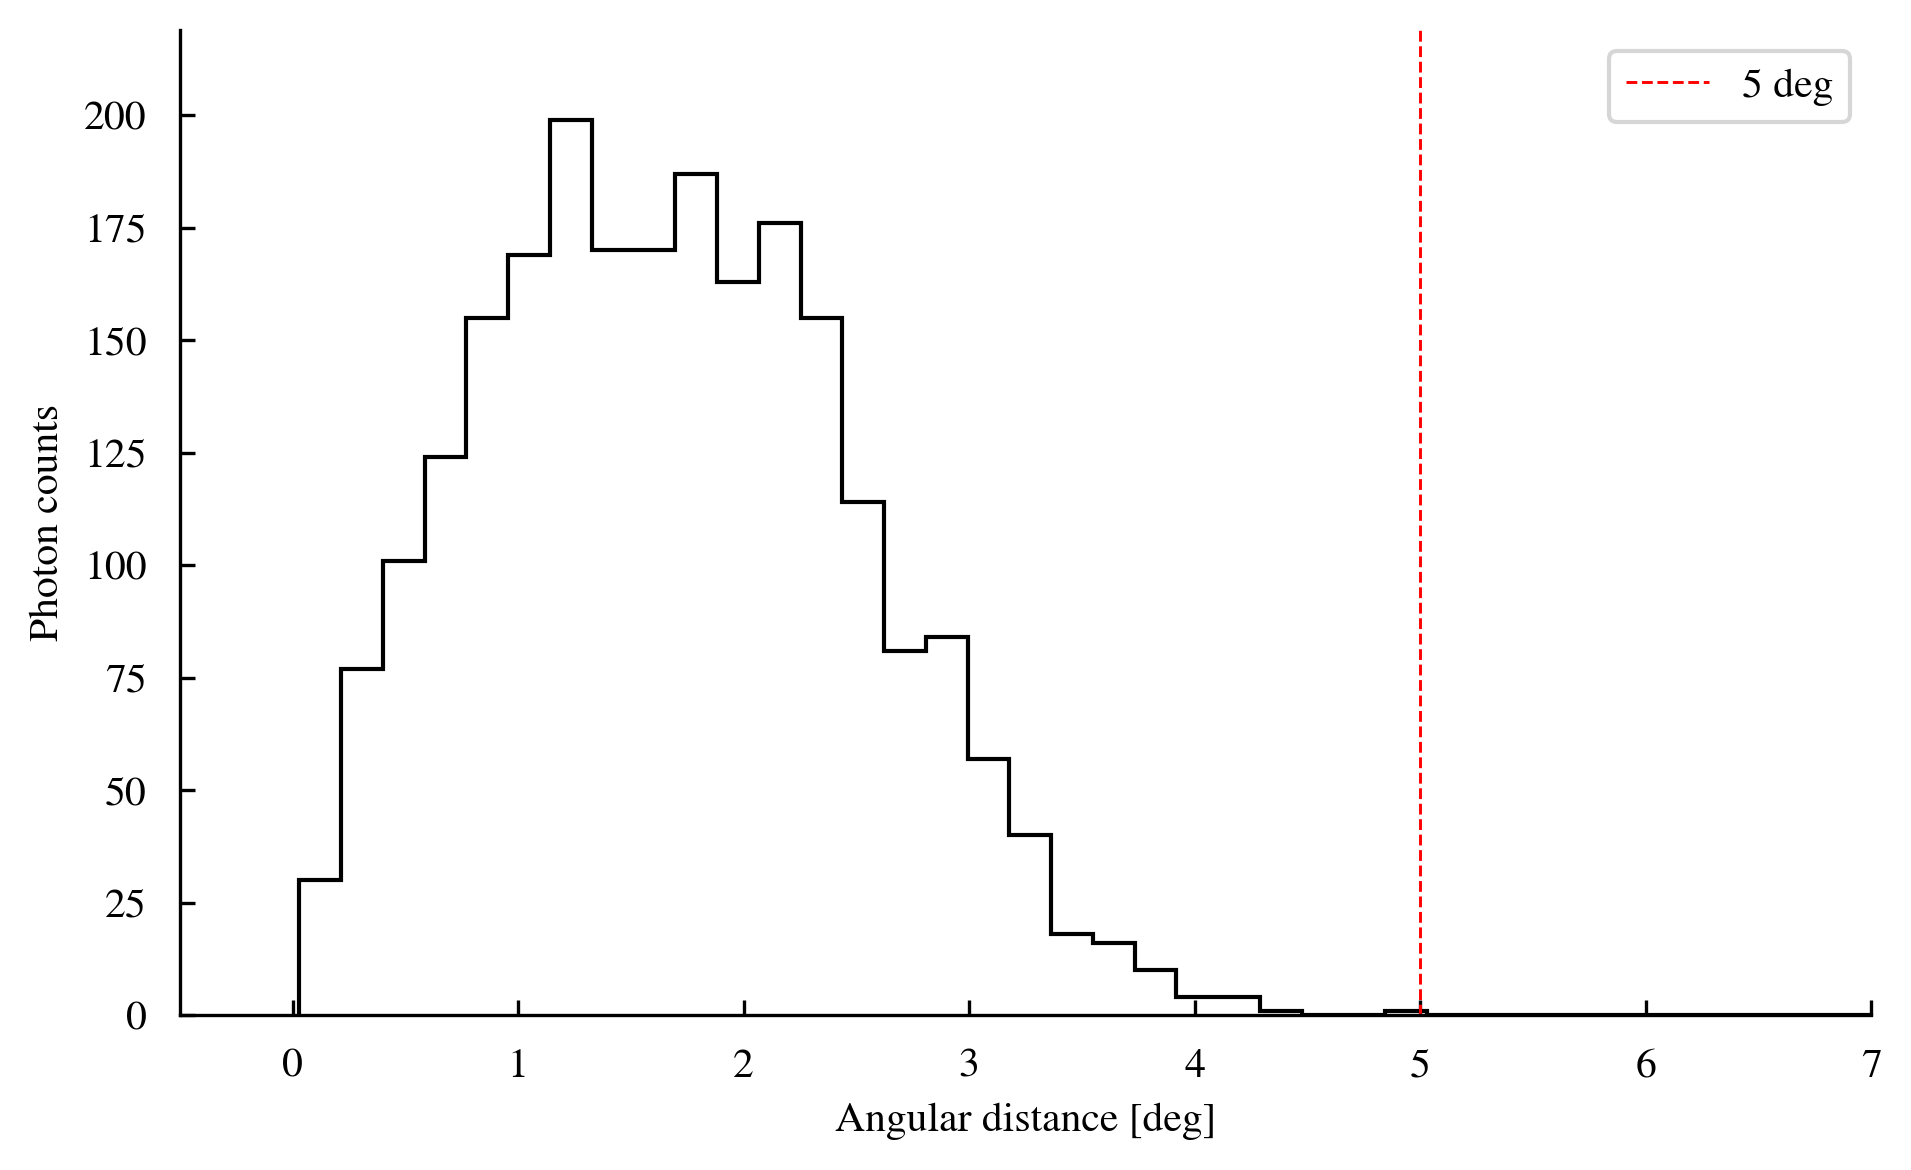

In [8]:
myhist = vis.hist(run_dist,histtype="step",bins="freedman")
plt.xlabel("Angular distance [deg]")
plt.ylabel("Photon counts")
# plt.title(f"Angular distance from median RADEC of multiplet to photons in run {obsids[current_obs_index]}")
ax = plt.gca()
ylims = ax.get_ylim()
plt.vlines(5,ylims[0],ylims[1],color="red",ls="--",label="5 deg")
ax.set_ylim(*ylims)
ax.set_xlim(-.5,7)
plt.legend()
# plt.yscale("log")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8


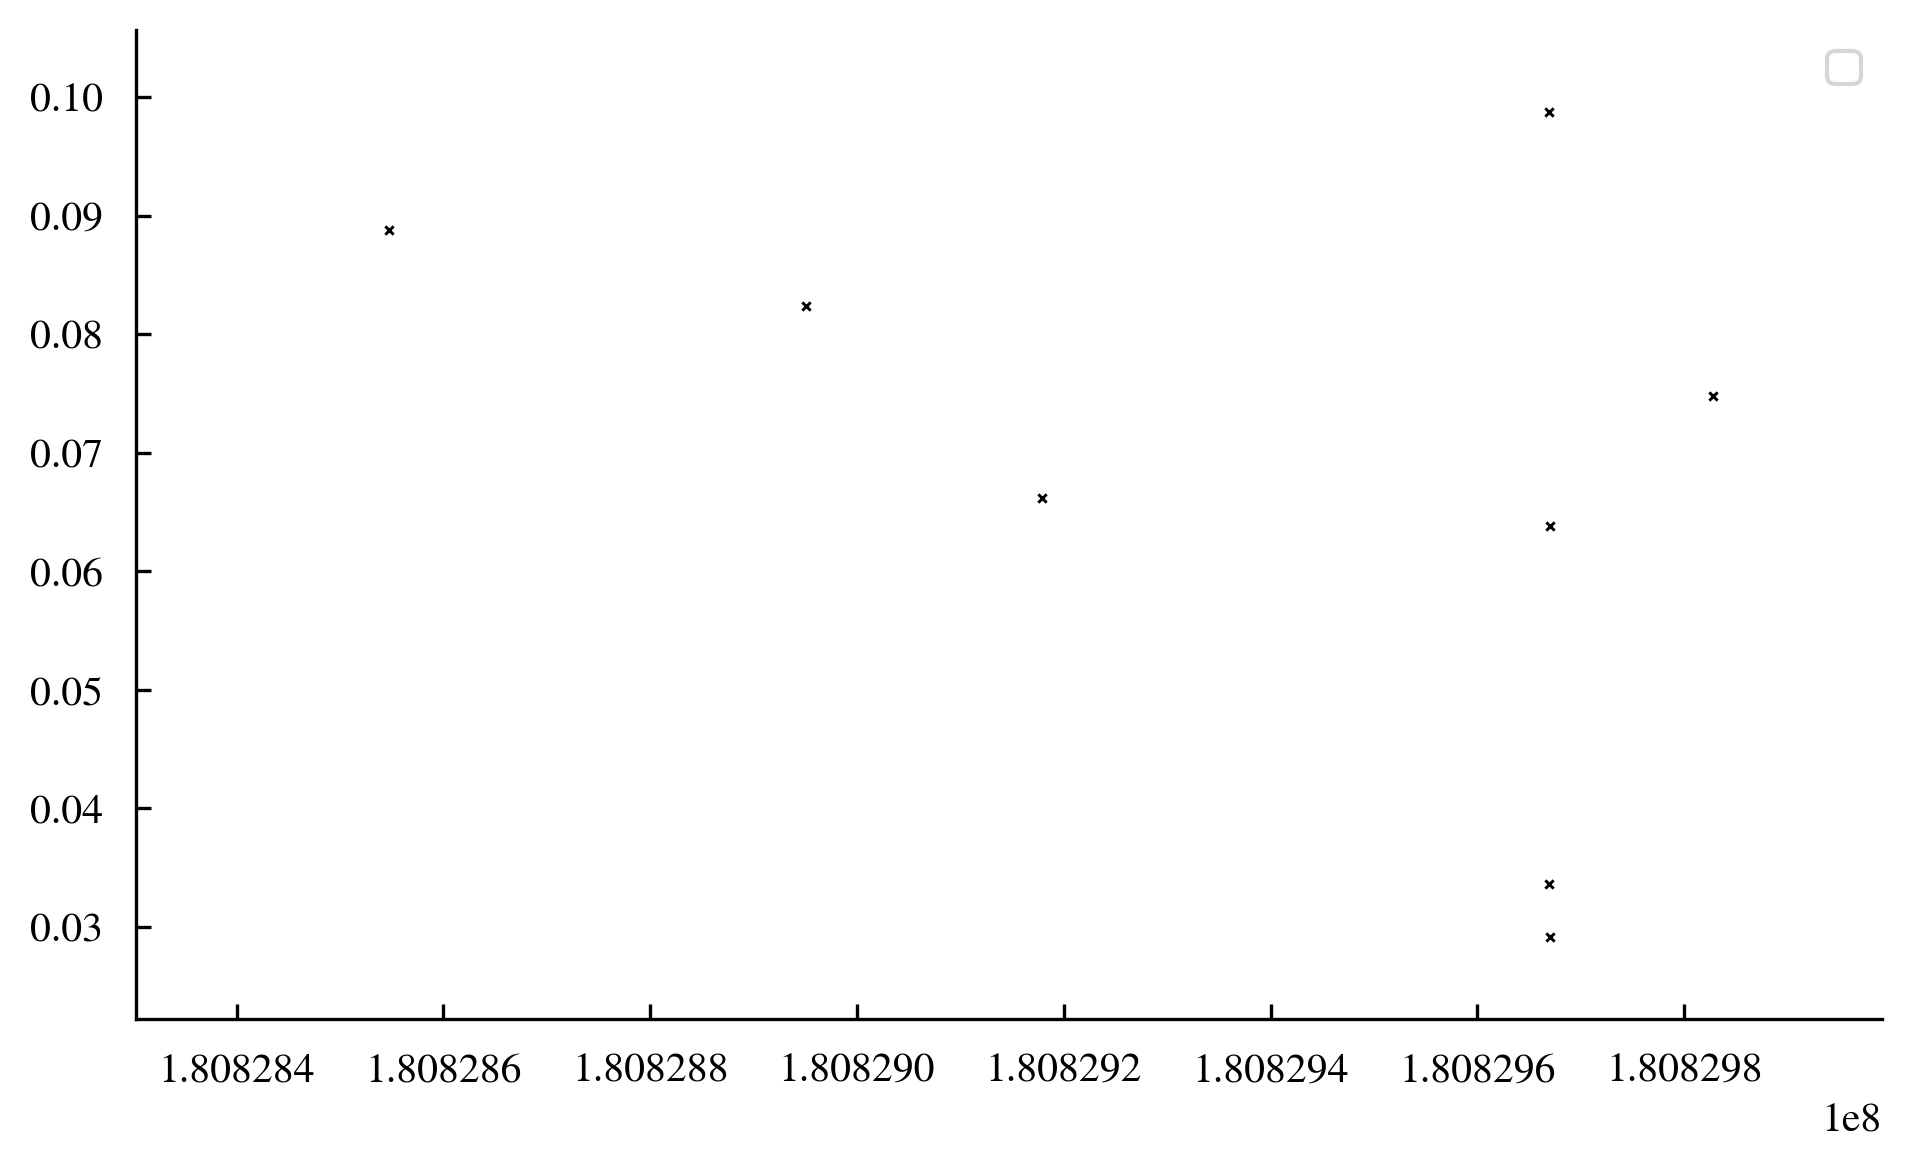

In [14]:
mask = run_dist < 0.1
photoncount = len(phottable[mask][:])#/myobs[0].obs_info["LIVETIME"]/60
print(photoncount)
plt.scatter(phottable[mask]["TIME"],run_dist[mask],s=4,marker="x")
plt.xlim(myobs.obs_info["TSTART"],myobs.obs_info["TSTOP"])
mplet_start_time_ns = reduced_row["TIME"][0].astype("float") - myobs.obs_info["TSTART"]
# plt.vlines(mplet_start_time_ns*1e-9,.98,1.02,color="red",label="mplet start time",ls="--")
# plt.legend()
plt.ticklabel_format(axis="x",style="sci",useOffset=False)
plt.show()

In [17]:
print(phottable[mask]["TIME"],"\n",run_dist[mask])


       TIME       
        s         
------------------
180828547.77256322
180828950.41976643
 180829178.5714972
  180829669.495579
 180829669.5254898
180829669.78794956
180829670.10159612
180829828.01819682 
 [0.08879278 0.08236309 0.06617037 0.09871879 0.03362451 0.02915861
 0.06384261 0.07480708]


In [19]:
toa_bkg = [180828547.77256322, 180828950.41976643, 180829178.5714972, 180829669.495579,180829828.01819682]
toa_sgl = [180829669.5254898, 180829669.78794956, 180829670.10159612]
print(toa_sgl[-1] - toa_sgl[0])
from scipy.stats import expon
from math import factorial
rate_bkg = 1.0/expon.fit(np.diff(toa_bkg),floc=0.)[1]
rate_sgl = 1.0 / expon.fit(np.diff(toa_sgl),floc=0)[1]

L = 3 * rate_bkg / rate_sgl
sum = 1
for i in range(3):
    sum -= L**i * np.exp(-L) / factorial(i)
print(sum)


0.5761063098907471
3.2737921173710724e-09


In [ ]:
from scipy.stats import expon
dt_run = np.diff(np.sort(phottable["TIME"]))
dt_mask = np.diff(np.sort(phottable[mask]["TIME"]))
params_run = expon.fit(dt_run)
params_mask = expon.fit(dt_mask)
print(f"params_run : {params_run}")
print(f"params_mask : {params_mask}")

In [ ]:
lambda_mask_fit = 1/params_mask[1]
rate_boe = len(phottable[mask])/myobs[0].obs_info["LIVETIME"]
print(lambda_mask_fit,rate_boe)

In [ ]:
# plt.hist(expon.rvs(*params_run,int(1e3)),histtype="step",label="rvs hist",density=True)
x = np.linspace(0,3,1000)
plt.plot(x,expon.pdf(x,*params_run))
plt.hist(dt_run,label="dt masked",density=True,histtype="step",color="blue")
plt.legend()
plt.show()

In [ ]:
rate_run = len(phottable)/myobs[0].obs_info["LIVETIME"]
rate_masked_run = len(phottable[mask])/myobs[0].obs_info["LIVETIME"]
print(rate_run,rate_masked_run)

## Analysing the navigation table

In [28]:
import dill
import numpy as np

with open("pickles/obs_id_to_index_per_ds_dict.pkl","rb") as f:
    navdict = dill.load(f)
with open("pickles/navigationtable.pkl","rb") as f:
    navtab = dill.load(f)

# with open("pickles/mplets.pkl", "rb") as f:
#     mplets = dill.load(f)

In [25]:
a = np.array([1,2],dtype=np.int64)
b = [1,2,3,3]
b[a[0]]

2

In [1]:
from scanner_interpretation import getDataStores
ds = getDataStores()


TypeError: 'numpy.int64' object is not iterable

In [3]:
type(ds[0].obs_ids)

numpy.ndarray

In [4]:
obs = ds[0].get_observations([ds[0].obs_ids[0]])
obs[0].obs_info

{'EXTNAME': 'EVENTS',
 'CREATOR': 'SASH FITS::EventListWriter',
 'TELESCOP': 'HESS',
 'ORIGIN': 'H.E.S.S. Collaboration',
 'INSTRUME': 'H.E.S.S. Phase I',
 'EV_CLASS': 'std_ImPACT',
 'OBS_ID': 18361,
 'TSTART': 96157130.0,
 'TSTOP': 96158011.0,
 'MJDREFI': 51910,
 'MJDREFF': 0.000742870370370241,
 'TIMEUNIT': 's',
 'TIMESYS': 'TT',
 'TIMEREF': 'local',
 'TASSIGN': 'Namibia',
 'TELAPSE': 0,
 'ONTIME': 881.0,
 'LIVETIME': 881.0,
 'DEADC': 1.0,
 'OBJECT': 'Crab Nebula',
 'RA_OBJ': 83.633333333333,
 'DEC_OBJ': 22.014444444444,
 'RA_PNT': 83.633333333333,
 'DEC_PNT': 22.514444444444,
 'GLON_PNT': 184.133314364185,
 'GLAT_PNT': -5.51637925194063,
 'ALT_PNT': 37.6661202492352,
 'AZ_PNT': 327.963142353231,
 'RADECSYS': 'FK5',
 'EQUINOX': 2000,
 'CONV_DEP': 0.0,
 'CONV_RA': 83.633333333333,
 'CONV_DEC': 22.014444444444,
 'OBS_MODE': 'WOBBLE',
 'N_TELS': 3,
 'TELLIST': '2,3,4',
 'GEOLAT': -23.2717777777778,
 'GEOLON': 16.5002222222222,
 'ALTITUDE': 1835.0,
 'MUONEFF': 0.0940089424451192,
 'MUONC

In [1]:
from tevcat import TeVCat, Source

tc = TeVCat()
tc.sources[0]

Unknown observatory name found in GRB 160821B:  None
Unknown "discoverer" ID found in GRB 160821B: None
Unknown observatory name found in SNR G004.8+6.2:  None
Unknown "discoverer" ID found in SNR G004.8+6.2: None
Unknown observatory name found in 3HWC J0621+382:  None
Unknown "discoverer" ID found in 3HWC J0621+382: None
Unknown observatory name found in 3HWC J0630+186:  None
Unknown "discoverer" ID found in 3HWC J0630+186: None
Unknown observatory name found in 3HWC J0631+107:  None
Unknown "discoverer" ID found in 3HWC J0631+107: None
